In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [ ]:
!unzip final_dataset.zip

Archive:  final_dataset.zip
warning [final_dataset.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [final_dataset.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
replace final_dataset/alces-alces/alces-alces_10_8b868536.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
# creo URL per file locale 

myFile = 'final_dataset.zip'
fullPath = os.path.abspath("./" + myFile) # or similar, depending on scenario
path_to_downloaded_file = tf.keras.utils.get_file(myFile, 'file://'+fullPath, extract=True)


1818066944/1818051748 [==============================] - 13s 0us/step


In [ ]:
os.chdir('/root/.keras/datasets/final_dataset')
!ls

 alces-alces		  impala			   pecora
 alga			  koala				   pesce
 anatra			  Leoni				   pinguino
 apis-mellifera		  lontra			   pipistrello
 avvoltoio		  lucertola			   polipo
 balena			  Lupi				   procyon-lotor
 bison-bison		  martes-americana		   puma
 bradypus-variegatus	  medusa			   puma-concolor
 cane			  mucca				   ragno
 canguro		 'n01443537(goldfish)'		   rattus-rattus
 capra			 'n01518878(ostrich)'		   rinoceronte
 cavallo		 'n01632777(axolotl)'		   scarafaggio
 cervo			 'n01644900(tailed_frog)'	   scimmia
 coniglio		 'n01669191(box_turtle)'	   scoiattolo
 crocodylus-niloticus	 'n01806143(peacock)'		   scorpione
 delfino		 'n01944390(snail)'		   serpente
 elefante		 'n02077923(sea_lion)'		   squalo
 farfalla		 'n02096294(Australian_terrier)'   tapiro
 fenicottero		  narvalo			   tapirus
 formica		  okapia-johnstoni		   Tigri
 gallina		  orcinus-orca			  'uccello grande'
 gatto			  ornithorhynchus-anatinus	  'uccello piccolo'
 Ghepardi		  orso				   vulpes-vulpes
 giraffa-cam

In [ ]:
batch_size = 128
img_height = 224
img_width = 224

#data_dir = '/root/.keras/datasets/final_dataset'
data_dir = '/work/final_dataset'

In [ ]:
# questo è un esempio di come si usa, nel caso di immagini suddivise in cartelle

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  labels='inferred',
  label_mode='int', #sparse categorical cross entropy, se categorical -> categorical c..e
  subset="training",
  color_mode='rgb',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  labels='inferred',
  label_mode='int',
  subset="validation",
  color_mode='rgb',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 70900 files belonging to 76 classes.
Using 56720 files for training.
Found 70900 files belonging to 76 classes.
Using 14180 files for validation.


In [ ]:
#class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['Ghepardi', 'Leoni', 'Lupi', 'Tigri', 'alces-alces', 'alga', 'anatra', 'apis-mellifera', 'avvoltoio', 'balena', 'bison-bison', 'bradypus-variegatus', 'cane', 'canguro', 'capra', 'cavallo', 'cervo', 'coniglio', 'crocodylus-niloticus', 'delfino', 'elefante', 'farfalla', 'fenicottero', 'formica', 'gallina', 'gatto', 'giraffa-camelopardalis', 'hippopotamus-amphibius', 'iguana-iguana', 'impala', 'koala', 'lontra', 'lucertola', 'martes-americana', 'medusa', 'mucca', 'n01443537(goldfish)', 'n01518878(ostrich)', 'n01632777(axolotl)', 'n01644900(tailed_frog)', 'n01669191(box_turtle)', 'n01806143(peacock)', 'n01944390(snail)', 'n02077923(sea_lion)', 'n02096294(Australian_terrier)', 'narvalo', 'okapia-johnstoni', 'orcinus-orca', 'ornithorhynchus-anatinus', 'orso', 'panda', 'panthera-onca', 'pappagallo', 'pecora', 'pesce', 'pinguino', 'pipistrello', 'polipo', 'procyon-lotor', 'puma', 'puma-concolor', 'ragno', 'rattus-rattus', 'rinoceronte', 'scarafaggio', 'scimmia', 'scoiattolo', 'scorpione', 'se

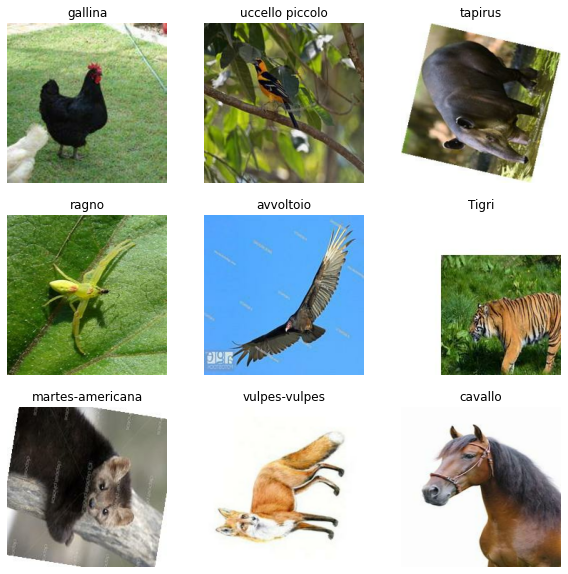

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = layers.Rescaling(1. / 255)
preprocessing_layer = layers.Lambda(
    tf.keras.applications.vgg16.preprocess_input, 
    output_shape=(224,224,3))
preprocessing_model = tf.keras.Sequential()
preprocessing_model.add(preprocessing_layer)
preprocessing_model.add(normalization_layer)

train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))
image_batch, labels_batch = next(iter(train_ds))

val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))
image_batch, labels_batch = next(iter(val_ds))

In [ ]:
#selection of pre-trained model

pt_model = tf.keras.applications.vgg16.VGG16(include_top=False,
    input_shape=(224, 224,3),
    weights='imagenet',
    pooling='avg')
    
for layer in pt_model.layers[0:-5]:
    layer.trainable = False

#pt_model.summary()


In [ ]:
# convert to Sequential model to add flatten
# this works with VGG16 because the structure is linear
model = keras.models.Sequential()
for layer in pt_model.layers:
    model.add(layer)
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dense(len(class_names)))
#model.summary()

In [ ]:
# loss and optimizer
# con un dataset non etichettato non si può usare categorical cross entropy
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.003) 
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max',verbose=2,patience=10,min_delta=0.0001)
checkpoint = ModelCheckpoint('/work/model/vgg_70k_class_pool.h5', monitor='val_loss', mode='min', save_best_only=True)
model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stopping,checkpoint])

Epoch 1/50
444/444 [==============================] - 594s 1s/step - loss: 3.0443 - accuracy: 0.2727 - val_loss: 2.4948 - val_accuracy: 0.3580
Epoch 2/50
444/444 [==============================] - 524s 1s/step - loss: 1.8899 - accuracy: 0.4852 - val_loss: 2.3705 - val_accuracy: 0.3858
Epoch 3/50
444/444 [==============================] - 531s 1s/step - loss: 1.5478 - accuracy: 0.5649 - val_loss: 2.1797 - val_accuracy: 0.4499
Epoch 4/50
444/444 [==============================] - 613s 1s/step - loss: 1.3393 - accuracy: 0.6157 - val_loss: 2.2974 - val_accuracy: 0.4236
Epoch 5/50
444/444 [==============================] - 522s 1s/step - loss: 1.2122 - accuracy: 0.6506 - val_loss: 2.2219 - val_accuracy: 0.4486
Epoch 6/50
444/444 [==============================] - 522s 1s/step - loss: 1.1005 - accuracy: 0.6786 - val_loss: 2.2023 - val_accuracy: 0.4697
Epoch 7/50
444/444 [==============================] - 522s 1s/step - loss: 0.9986 - accuracy: 0.7063 - val_loss: 2.2535 - val_accuracy: 0.4667

In [ ]:
### metric and evaluation

In [ ]:
mod_feature_extr = load_model('/content/drive/MyDrive/model/effnet70kclass_pool.h5')

In [ ]:
mod_feature_extr.summary()

In [ ]:
feat_extr = tf.keras.models.Sequential()
for layer in mod_feature_extr.layers[0:-2]:
  feat_extr.add(layer)

In [ ]:
feat_extr.summary()

In [ ]:
gallery_dir = ''
query_dir = ''

In [ ]:
print(len(gallery_dir))
print(len(query_dir))

In [ ]:
from PIL import Image
for fl in os.listdir(query_dir):
  img1 = Image.open(query_dir+fl)
  n = fl[:-3]
  img1.save(query_dir + n +'jpeg')
  os.remove(query_dir+fl)

for f in os.listdir(gallery_dir):
  img1 = Image.open(gallery_dir+f)
  n = f[:-3]
  img1.save(gallery_dir + n +'jpeg')
  os.remove(gallery_dir+f)


In [ ]:
gallery_ds = tf.keras.utils.image_dataset_from_directory(
  gallery_dir,
  labels=None,
  color_mode='rgb',
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

query_ds = tf.keras.utils.image_dataset_from_directory(
  query_dir,
  labels=None,
  shuffle=False,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
gallery_features = feat_extr.predict(gallery_ds)
query_features = feat_extr.predict(query_ds)

In [ ]:
pairwise_dist = scipy.spatial.distance.cdist(query_features, gallery_features, 'minkowski', p=2.)

In [ ]:
indices = np.argsort(pairwise_dist, axis=-1)

In [ ]:
res_dict=dict()
res_dict["groupname"] = "request"
res_dict["images"] = dict()

In [ ]:
def load_image3(file_path):
  img = tf.keras.utils.load_img(file_path, color_mode='rgb', target_size=(224,224), interpolation='nearest')
  img = tf.keras.utils.img_to_array(img)
  img /=255
  return img

def k_nn(query_num, k):
  global res_dict
  li = []
  #print(query_label[query_num])
  immagine = load_image3(query_ds.file_paths[query_num])
  plt.imshow(immagine)
  chiave = query_ds.file_paths[query_num]
  chiave = chiave[28:-4]+'jpg'

  fig = plt.figure(figsize=(25,10))
  for i, match in enumerate(indices[query_num][:k]):
    #print(gallery_label[match])
    nn = load_image3(gallery_ds.file_paths[match])
    ob = gallery_ds.file_paths[match]
    ob = ob[30:-4]+'jpg'
    li.append(ob)
    fig.add_subplot(1,len(indices[query_num][:k]),i+1)
    plt.imshow(nn)
  
  res_dict["images"][chiave] = li

In [ ]:
for q in range(len(query_ds.file_paths)):
  k_nn(q,10)

In [ ]:
import json
with open("./result_vgg_eucl.json","w") as f:
        json.dump(res_dict, f)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bbd97b73-ed83-4849-b2dc-b904e8505536' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>